<img src="Resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center"> Workshop 1: Tutorial on behavioral states</h1> 
<h2 align="center"> Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center"> Thursday, August 24th, 2023</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> During the lecture, we learned about behavioral states and how they are a link between sensory inputs and motor responses. In this workshop, we will explore how to define behavioral states and to study the external markers of states changes and neural activity. We will examine these phenomena in mice while they perform a visual change detection task. 

<p> During the task, the mice are visually engaged, interact with their environment, and portray several behavioral profile sequences. Meanwhile, Neuropixels electrodes record spiking activity across the visual cortex and several hippocampal and thalamic nuclei. The behavioral task, therefore, offers an opportunity to study the dynamics of spiking activity during various behavioral states and aids in understanding the behavioral dynamics of task engagement.     
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

pd.set_option('display.max_columns', None)

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> First, we will introduce the Visual Behavior Neuropixels dataset (<a href="https://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels">link to Allen Institute website describing dataset</a>). This dataset consists of recordings of neural activity measured using 6 Neuropixels probes from mice that have learned to perform an image change detection task.  Recordings are made simultaneously from neurons distributed across layers in the visual cortex ( VISp, VISl, VISal, VISrl, VISam, and VISpm), neurons in the hippocampus (CA1/3, DG), and neurons in the visual thalamus (LP and LGd).
    
<p> In this go/no-go task task, mice are shown a series of visual images that are briefly presented (250 ms) and they earn water rewards by correctly reporting (licking the reward spout) when the identity of the image changes (diagrammed below). 
     
</div>

<img src="Resources/download.png">  

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
The Visual Behavior Neuropixels dataset is accessed with the Python module `VisualBehaviorNeuropixelsProjectCache`.  We begin by importing this module.
We also provide the path to the NWBs that store the session information from all mice.
    
</div>

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache_dir  = data_root

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=cache_dir, use_static_cache=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let us look at a single experimental session and examine the metadata  recorded for each behavioral trial.
</div>

In [4]:
example_sessions = [1139846596, 1124507277, 1069461581]

session_id = example_sessions[0] 
session = cache.get_ecephys_session(session_id)

trial_metadata = session.trials # 'trials' is a dataframe that contains metadata and task information for each trial

display(trial_metadata.iloc[10:20].head()) # to do: add precomputed response time? 

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
10,68.21075,76.23431,im114_r,im024_r,True,71.96442,False,False,"[72.581, 72.68075, 72.78081, 72.8976, 73.01423...",72.58100,72.13147,0.005,False,False,False,False,False,True,2716.0,8.02356
11,76.46747,79.43677,im024_r,im024_r,False,NaN,False,False,[79.12019],NaN,NaN,0.000,False,False,False,False,True,False,NaN,2.96930
12,79.47013,81.13830,im024_r,im024_r,False,NaN,False,False,"[80.67133, 80.82089]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,1.66817
13,81.72219,88.97824,im024_r,im104_r,True,84.72478,True,False,"[85.22592, 85.3412, 85.44124, 85.52476, 85.624...",85.22592,85.22592,0.003,True,False,False,False,False,False,3481.0,7.25605
14,89.22820,93.11532,im104_r,im104_r,False,NaN,False,False,"[92.64816, 92.79754]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,3.88712


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How well does the mouse recognize a change in the image sequences? We can quantify their performance by evaluating the fraction of 'go' trials during which the mouse licked the spout.      
</div>

In [5]:
num_go_trials = len(np.where(trial_metadata.go)[0])
num_go_hit_trials = len(np.where(trial_metadata.go[trial_metadata.hit])[0])
print('Proportion of trials correctly performed: ' + str(np.round(num_go_hit_trials/num_go_trials, 2)))

Proportion of trials correctly performed: 0.46


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  We have listed three example sessions here, access the metadata from each of the sessions. Print the proportion of 'go' trials that the mouse performed correctly and evaluate their mean performance. (Note: session = get_session(session_id) will take a minute or two to load the session))
</div>

<b>Please be wary while naming variables. Do not use variable names that are already assigned. Preferably, append the number corresponding to the example you are analyzing as we have done below. For example, if analyzing example mouse 2, use num_go_trials_2, etc. </b>

In [6]:
# Blank coding cell to work out Task 1.1  

# Here, we have included the code to load the data from the other example mice.
session_2 =  cache.get_ecephys_session(example_sessions[1])
trial_metadata_2 = session_2.trials

session_3 =  cache.get_ecephys_session(example_sessions[2])
trial_metadata_3 = session_3.trials


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Looks like these mice fail to respond in about 20-50% of the trials!

<p> Next, we will their plot licking patterns for each 'go' trial to get a sense of when they are failing to respond.
</div>

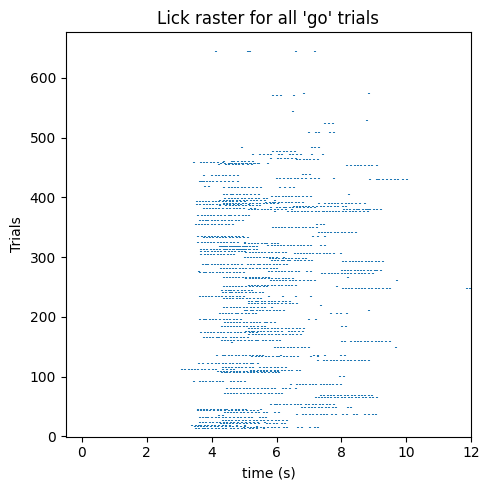

In [7]:
# Get lick times for each 'go' trial. Note: we subtract the trial start time so lick times are relative to trial start
lick_times = trial_metadata[trial_metadata.go].lick_times.values - trial_metadata[trial_metadata.go].start_time.values

# Get 'go' trial numbers
go_trials =  trial_metadata[trial_metadata.go].index

# generate plot
fig, ax = plt.subplots(figsize = (5, 5))
ax.eventplot(lick_times, linelength = 1.5, lineoffsets = go_trials);

# Add labels to plot
ax.set_ylim(-0.5, go_trials[-1]+4)
ax.set_xlim(-0.5, 12)
ax.set_ylabel('Trials')
ax.set_xlabel('time (s)')
ax.set_title("Lick raster for all 'go' trials")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Interestingly, this mouse licks on many 'go' trials during the first part of the session but then rarely licks during the later trials.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b> Plot lick rasters for the other example mice. What do their lick trends look like?
</div>

<b>Please be wary while naming variables.  </b>

In [8]:
# Blank coding cell to work out Task 1.2  
# hint: use "trial_metadata_2" and "trial_metadata_3"

# lick_times2 = 

# fig, ax = plt.subplots(figsize = (5, 5))
# ax.eventplot(lick_times2, linelength = 1.5);

# # Add labels to plot
# ax.set_ylim(-0.5, len(lick_times2))
# ax.set_xlim(-0.5, 12)
# ax.set_ylabel('go trials')
# ax.set_xlabel('time (s)')
# ax.set_title("Lick raster for all 'go' trials")
# plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> So, these mice seem to stop responding during the later trials in the session. Another way of looking at this data is to plot the number of licks in each trial. Here, we will plot licks for all trial types inlcuding 'go', 'catch', and 'aborted' trials.  
</div>

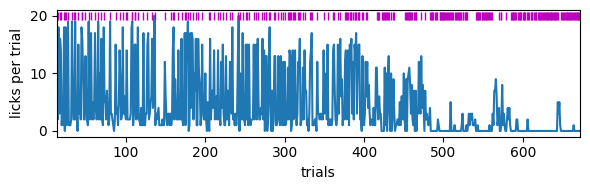

In [9]:
fig, ax = plt.subplots(figsize = (6, 2))

# lambda function!!
lick_count = trial_metadata.apply(lambda row : len(row['lick_times']), axis = 1)

# Plot lick count
ax.plot(lick_count)

# Plot marker indicating 'go' trials
go_trials =  trial_metadata[trial_metadata.go].index
ax.plot(go_trials,20*np.ones(len(go_trials)),'|', color = 'm') 

# Formatting
ax.set_ylabel('licks per trial')
ax.set_xlabel('trials')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

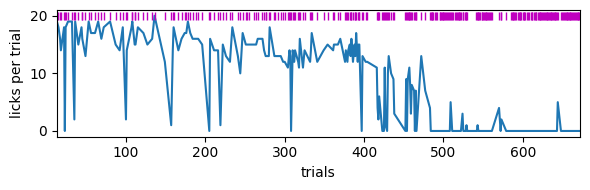

In [10]:
# Same plot as above, but only for 'go' trials
fig, ax = plt.subplots(figsize = (6, 2))

# Select 'go' trials
lick_count = trial_metadata[trial_metadata.go].apply(lambda row : len(row['lick_times']), axis = 1)

# Plot lick rate
ax.plot(lick_count)

# Plot marker indicating 'go' trials
ax.plot(go_trials,20*np.ones(len(go_trials)),'|', color = 'm') 

# Formatting
ax.set_ylabel('licks per trial')
ax.set_xlabel('trials')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Could the mouse be disenaging from the task as they reach the end of the session? The reduction in licking seems to indicate this. 
<p> Next, we can quantify performance by computing the hit rate over the behavioral session. Hit rate is the probability the mouse correctly performs a lick during 'go' trials. Here, we will evaluate this as the fraction, over 10 go-trials, in which the mouse licked correctly to the image change.
    
</div>

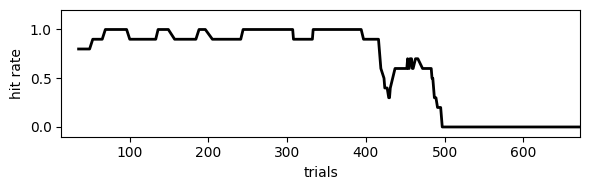

In [11]:
# Compute hit rate with 10 trial rolling window.
hit_rate = trial_metadata.hit[trial_metadata.go].rolling(10).mean()

fig,ax = plt.subplots(figsize = (6, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)

# Formatting
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')

plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We see that the hit rate is very high during the first 400 trials, then drops to zero around trial 500. Thus, the mouse is clearly "task engaged" during the first part of the session, but then becomes "task disengaged". Using this insight we can set an  threshold on hit rate to define engaged and disengaged states. 
</div>

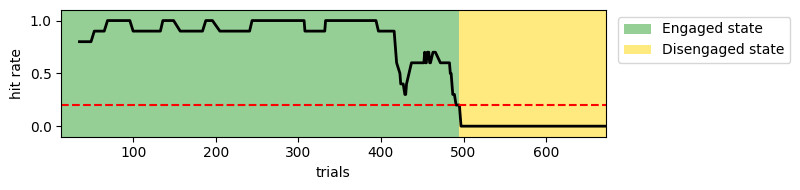

In [12]:
# Threshold for defining engageded vs disengaged states
engagement_threshold = 0.2

fig,ax = plt.subplots(figsize = (8.2, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials, engagement_threshold*np.ones(num_go_trials), color = 'r', ls = '--')

# Determine state transition boundaries
states = hit_rate < engagement_threshold
switch_trials = np.where(np.diff(states.values))[0]
switch_trials = np.concatenate(([0], switch_trials, [num_go_trials-1]))

# Plot boundaries to mark state transitions
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5, label = 'Engaged state')
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5,label = 'Disengaged state')

# Formatting
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3:</b> Evaluate the correlation between hit rate and lick count during 'go' trials. 
</div>

In [13]:
# Blank coding cell to work out Task 1.3 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> When the mouse disengages from the task, does it also change other aspects of its behavior? For instance, does the mouse's running speed change or the size of its pupil? We'll look at this next.
</div>

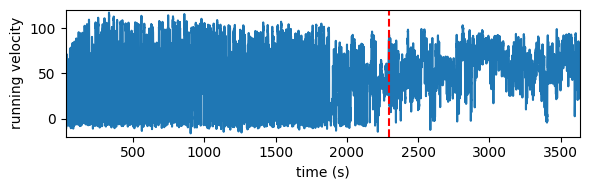

In [14]:
# Get running speed and corresponding timestamps
running_time = session.running_speed.timestamps
running_speed = session.running_speed.speed

stop_time = trial_metadata.stop_time.max()
start_time = trial_metadata.start_time.min()

# Compute the time when mouse switches from engaged to disengaged state
time_at_switch = trial_metadata.iloc[go_trials[np.where(np.diff(states.values))[0]]].start_time.values

# Plot running speed
fig,ax = plt.subplots(figsize = (6, 2)) 
plt.plot(running_time, running_speed)

# Plot boundaries to mark state transitions
for i in range(len(time_at_switch)):
    plt.plot(time_at_switch[i]*np.ones(5), np.linspace(-20, 120, 5), color = 'r' , ls = '--')
    
# Formatting
ax.set_xlim(start_time, stop_time)
ax.set_ylim(-20, 120)
ax.set_xlabel('time (s)')
ax.set_ylabel('running velocity')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> This plot is noisy and it is difficult to point out trial-wise changes in the running speed. We can smooth this plot out and analyze mean running speed in each trial to find any correlates of state transitions in the go trials.  
</div>

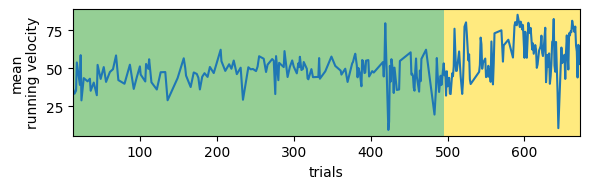

In [15]:
# Get timestamps corresponding to go trials
trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

# Compute mean running speed in each go trial
mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# Plot mean speed
fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(go_trials, mean_speed)

# Plot boundaries to mark state transitions
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5)

# Formatting
ax.set_xlabel('trials')
ax.set_ylabel('mean\nrunning velocity')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> This plot shows that mice run at a higher average velocity when they are disengaged. Let us analyze this behavior more closely.  
</div>

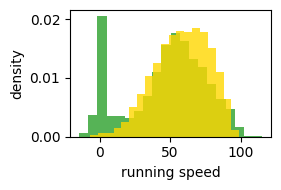

In [16]:
# Histogram of running speed during engaged and disengaged trials

def flatten(l):
    # function to flatten a list of lists 
    return np.array([item for sublist in l for item in sublist])

# Define empty lists that we'll populate below
engaged_speed = []
disengaged_speed =[]

engaged_time = []
disengaged_time =[]

# Accumulate running speed values for engaged and disengaged trials into separate lists
for index, state in states.items():
    t_start = trial_metadata.iloc[index].start_time
    t_stop = trial_metadata.iloc[index].stop_time
    t = np.where((running_time >= t_start) & (running_time <= t_stop))[0]
    if not state:
        engaged_speed.append(running_speed[t])
        engaged_time.append(running_time[t])
    else:
        disengaged_speed.append(running_speed[t])
        disengaged_time.append(running_time[t])

# Plot histograms
fig,ax = plt.subplots(figsize = (3, 2)) 
plt.hist(flatten(engaged_speed), bins = 20, color = 'tab:green', density = True, alpha = 0.8);
plt.hist(flatten(disengaged_speed), bins = 20, color = 'gold', density = True, alpha = 0.8);

# Formatting
plt.ylabel('density')
plt.xlabel('running speed')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Mice seem to be stopping (running speed = 0) a lot more in the engaged state. To see why, we can look at the running speeds during engaged states. 
</div>

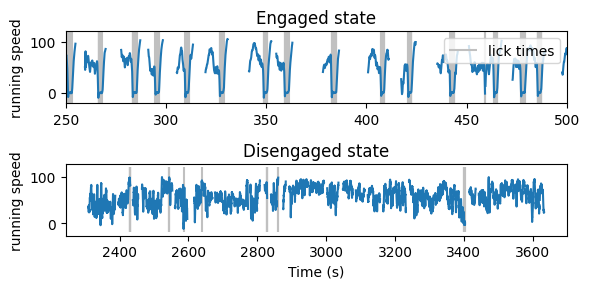

In [17]:
# Get lick times for each 'go' trial and assign values for engaged and disengaged trials into separate dataframes
lick_times = trial_metadata[trial_metadata.go].lick_times
engaged_lick_times = lick_times[~states.values]
disengaged_lick_times = lick_times[states.values]

fig, ax = plt.subplots(2, 1, figsize = (6, 3))

# Plot for engaged state
for time, speed in zip(engaged_time, engaged_speed):
    ax[0].plot(time, speed, color = 'tab:blue')

# Formatting
ax[0].vlines(flatten(engaged_lick_times.values), ymax = 120, ymin = -20, color = 'silver', label = 'lick times')
ax[0].set_ylim(-20, 120)
ax[0].set_xlim(250,500)
ax[0].legend(loc = 'upper right')
ax[0].set_ylabel('running speed')
ax[0].set_title('Engaged state')

# Plot for disengaged state
ax[1].set_title('Disengaged state')
for time, speed in zip(disengaged_time, disengaged_speed):
    ax[1].plot(time, speed, color = 'tab:blue')
    
# Formatting
ax[1].vlines(flatten(disengaged_lick_times.values), ymax = 120, ymin = -20, color = 'silver', label = 'lick times')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylim(-20, 120)
# ax[1].set_xlim(3000,3250) # change limits for different mice
ax[1].set_ylabel('running speed')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We can see that mice stop running when they lick the spout to recieve the water reward. This act of stopping, then, seems to be externally driven. Is there a more internally driven behavioral metric we can look at? Pupil size/area is commonly used to measure arousal levels in mice. Let us see how this metric varies during the engaged and disengaged states. 
</div>

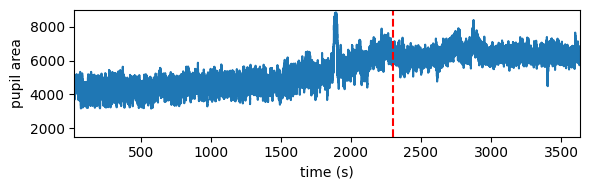

In [18]:
# Get pupil size and associated timestamps
pupil_time = session.eye_tracking.timestamps
pupil_area = session.eye_tracking.pupil_area

# Plot pupil size
fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(pupil_time, pupil_area)

# Plot boundaries to mark state transitions 
for i in range(len(time_at_switch)):
    plt.plot(time_at_switch[i]*np.ones(5), np.linspace(1500, 9000, 5), color = 'r' , ls = '--')
    
# Formatting
ax.set_xlim(start_time, stop_time)
ax.set_ylim(1500, 9000)
ax.set_xlabel('time (s)')
ax.set_ylabel('pupil area')
plt.tight_layout()

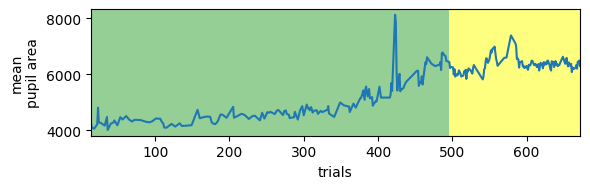

In [19]:
# Get timestamps corresponding to go trials
trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

# Compute mean pupil size in each go trial
mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# Plot mean pupil size
fig,ax = plt.subplots(figsize = (6, 2))
plt.plot(go_trials, mean_pupil_area)

# Mark transition boundaries
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='yellow', alpha=0.5)

# Formatting
ax.set_xlabel('trials')
ax.set_ylabel('mean\npupil area')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Here we can see that pupil size gradually increasing as the session ends. Could this be a good predictor of a state transition? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.4:</b> Plot mean pupil area across trials for the other mice. Do these mice also show a change in pupil area that correlates with task disengagement? 
</div>

In [20]:
# Blank coding cell to work out Task 1.4


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Up to this point we have examined how mouse task performance varies across a behavioral sesssion. From this we inferred "behavioral states" (engaged vs disengaged) and showed that these correlate with running behavior and pupil dynamics. We assume that changes in behavioral state reflect changes in "internal brain states". However, we have only observed these states indirectly through the mouse's behavior.The states we infer from behavior can offer clues for when we should look for changes in the underlying neural activity. Thus, we next turn our attention to see whether neural activity might differ between the two behavioral states we've inferred. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We will folow these steps to analyze the neuronal spiking data:
<ul>
    <li>Access unit data from one Neuropixels probe</li>
    <li>Pick an area of interest</li>
    <li>Filter units based on quality control metrics (see VBN DataBook for details)</li>
    <li>Plot spiking responses for units during engaged and disengaged states</li>
</ul>
</div>

In [21]:
# Select units from Neuropixels probeA (reminder: each recording includes up to 6 probes (A-F) that target different brain regions)
probe_id = session.probes[session.probes.name == 'probeA'].index.values
unit_table = session.get_units(probe_id, amplitude_cutoff_maximum = 0.1, 
                               presence_ratio_minimum = 0.9, isi_violations_maximum = 0.5) # to do: this table does not include ccf location. 
unit_table = cache.get_unit_table().loc[unit_table.index.values] 

unit_table.value_counts('structure_acronym')

structure_acronym
CA1      185
VISp      88
VISpm     64
VISam     63
VISal     56
VISl      55
DG        52
MGv       47
CA3       46
PIL       41
VISrl     39
SUB       29
APN       25
ProS      21
MB        16
SCig      14
TH        12
MGm        9
PoT        8
LP         7
MGd        3
MRN        1
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> An easy way to learn more about these regions is through the Allen Brain Atlas at: <a href="http://connectivity.brain-map.org/3d-viewer?v=1&types=PLY&PLY=549%2C512%2C669">Link here</a>
</div>

In [22]:
# Select units from our area of interest
area_of_interest = ['CA1'] # region in the hippocampus!
unit_nos = np.array([idx for idx, ccf in enumerate(unit_table.structure_acronym.values) if ccf in area_of_interest])

unit_ids = unit_table.index[unit_nos]
final_unit_table = unit_table.loc[unit_ids]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> The "unit table" is a dataframe that contains metadata for each recording unit. See the VBN DataBook for more information.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.5:</b> Display the first 10 elements of the final_unit_table index and decide how to study the question: does this neuron change its activity between engaged and disengaged?
</div>

In [23]:
# Blank coding cell to work out Task 1.5

In [24]:
final_unit_table.head(10)

,ecephys_channel_id,ecephys_probe_id,ecephys_session_id,amplitude_cutoff,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,cumulative_drift,d_prime,structure_acronym,structure_id,firing_rate,isi_violations,isolation_distance,l_ratio,local_index,max_drift,nn_hit_rate,nn_miss_rate,presence_ratio,probe_horizontal_position,probe_vertical_position,silhouette_score,snr,valid_data,amplitude,waveform_duration,waveform_halfwidth,PT_ratio,recovery_slope,repolarization_slope,spread,velocity_above,velocity_below
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153690052,1153687708,1140043047,1139846596,0.000141,8259.0,1805.0,7828.0,318.03,-2.898115,CA1,382,5.910581,0.005656,65.988995,2.364148e-03,141,48.88,0.965625,0.001825,0.99,27.0,1720.0,0.125111,1.881085,True,299.739375,0.521943,0.164824,0.318786,-0.065527,0.971603,100.0,-0.040879,-0.343384
1153690039,1153687708,1140043047,1139846596,0.008974,8259.0,1805.0,7828.0,283.43,4.355720,CA1,382,1.358117,0.021427,58.407137,1.179543e-03,129,34.42,0.783333,0.000704,0.99,27.0,1720.0,0.095596,1.751574,True,304.862415,0.521943,0.247236,0.413753,-0.088197,0.686819,120.0,-0.359735,-0.824121
1153690250,1153687719,1140043047,1139846596,0.000674,8234.0,1673.0,7821.0,178.03,-4.835822,CA1,382,0.938199,0.314250,41.009030,5.957086e-03,333,15.27,0.642424,0.001274,0.99,11.0,1820.0,0.042809,2.945413,True,310.649625,0.755444,0.178559,0.270188,-0.092425,0.915873,60.0,-0.686767,-0.549414
1153690249,1153687719,1140043047,1139846596,0.053261,8234.0,1673.0,7821.0,0.00,3.538234,CA1,382,0.095834,0.000000,34.298465,4.065786e-03,332,14.10,0.066667,0.000100,0.99,11.0,1820.0,0.014141,2.269515,True,238.246452,0.576884,0.178559,0.355948,-0.134676,0.875156,90.0,11.331658,-0.662240
1153690248,1153687719,1140043047,1139846596,0.001358,8234.0,1673.0,7821.0,146.70,4.983812,CA1,382,2.095055,0.009003,61.437439,1.119818e-03,331,24.49,0.935484,0.000709,0.99,11.0,1820.0,0.091640,2.833849,True,290.132895,0.549414,0.178559,0.409875,-0.161638,0.985742,110.0,2.128978,-0.343384
1153690086,1153687719,1140043047,1139846596,0.000027,8234.0,1673.0,7821.0,144.66,-5.082198,CA1,382,1.014740,0.038376,48.782946,2.672203e-03,175,23.20,0.838889,0.000201,0.99,11.0,1820.0,0.093044,3.700753,True,393.892395,0.714238,0.164824,0.286465,-0.133036,1.339946,60.0,-1.373534,-1.030151
1153690085,1153687719,1140043047,1139846596,0.010864,8234.0,1673.0,7821.0,287.77,-3.594694,CA1,382,1.856789,0.217794,52.624946,3.085666e-03,174,20.31,0.754545,0.002730,0.99,11.0,1820.0,0.042667,2.043363,True,199.373655,0.865327,0.192295,0.288373,-0.059740,0.590500,70.0,0.686767,-0.961474
1153690084,1153687719,1140043047,1139846596,0.081727,8234.0,1673.0,7821.0,12.61,3.282815,CA1,382,0.071374,0.000000,27.123321,1.452396e-02,173,21.07,0.000000,0.000167,0.98,11.0,1820.0,NaN,2.102783,True,231.358139,0.467002,0.233501,0.538029,-0.074558,0.749075,100.0,2.060302,-0.351559
1153690083,1153687719,1140043047,1139846596,0.055243,8234.0,1673.0,7821.0,101.24,-3.833312,CA1,382,7.433587,0.084387,80.719418,1.837169e-03,172,23.92,0.963047,0.003627,0.99,11.0,1820.0,0.112298,2.342968,True,231.066030,0.604355,0.151089,0.282826,-0.064821,0.780183,60.0,-1.373534,-0.618090


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Now that we have information about our units, let us access their spike times. Spike times for each unit are stored in the "session" object in data stucture called "spike_times". See the VBN DataBook for more information about the session object. 
</div>

In [25]:
# Let's count the number of times this neuron spiked over the whole session.
unit = 1153690093
unit_data = session.spike_times[unit]

numberofspikes = unit_data.shape[0]
print('Neuron {} spiked {} times during this session.'.format(unit, numberofspikes))

Neuron 1153690093 spiked 91006 times during this session.


Text(0, 0.5, 'trials')

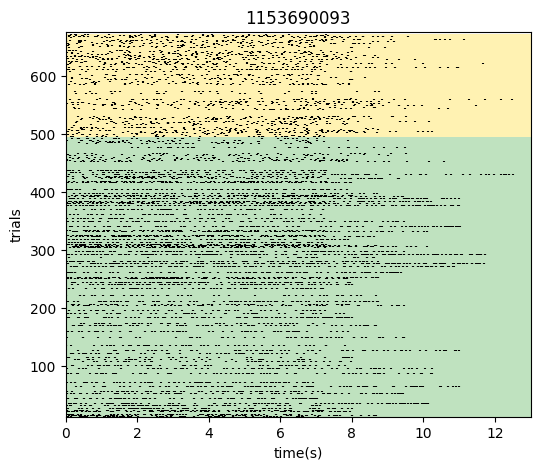

In [26]:
# Look at unit data
unit = 1153690093
unit_data = session.spike_times[unit]

# define the 'go' trials that we want to study
start_times = trial_metadata[trial_metadata.go].start_time
stop_times = trial_metadata[trial_metadata.go].stop_time

spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    
# Plot raster of spike times
fig, ax = plt.subplots(1,1, figsize = (6, 5))
ax.eventplot(spike_times, color = 'k', lineoffsets = go_trials);

#add the engaged and disengaged determination
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.3)
    else:
        ax.axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.3)

# Format each axis in the loop
ax.set_title(unit)    
ax.set_ylim(go_trials[0], go_trials[-1]+4)
ax.set_xlabel('time(s)')
ax.set_xlim(0, 13)
ax.set_ylabel('trials')

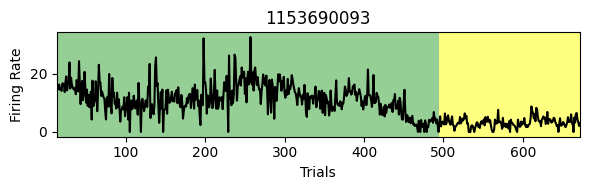

In [27]:
# Let's calculate the average firing rate in each trial
unit = 1153690093
unit_data = session.spike_times[unit]

# define the all the trials that we want to study
start_times = trial_metadata.start_time
stop_times = trial_metadata.stop_time

spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
spike_rate = [float(spike_times[a].shape[0])/(stop_times[i]-start_times[i]) for a, i in enumerate(start_times.index)]

# plot the firing rate up
fig, ax = plt.subplots(1,1,figsize=[6,2])

ax.plot(spike_rate, 'k')
ax.set_title(unit)  

# Mark transition boundaries
for i, trial in enumerate(switch_trials[:-1]):
    if not states.values[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='yellow', alpha=0.5)

# Plotting formatting
ax.set_title(unit)
ax.set_xlabel('Trials')
ax.set_ylabel('Firing Rate')
ax.set_xlim(go_trials[0], go_trials[-1])
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> With this neuron's compelling relationship with disengagement, it becomes natural to ask more about this single neuron. In the neuropixels dataset, there are a sundry of summary measures relating to the waveform of each unit acquired from spike-sorting. Let's take a moment to explore one of them: and way to look in a more detailed way at the spike waveform.
</div>

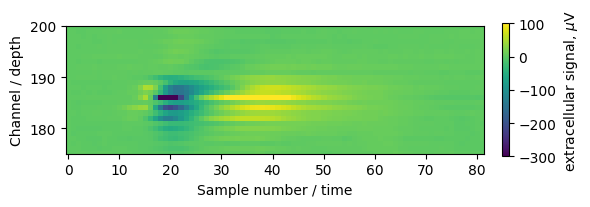

In [28]:
# extract the waveforms table so that we can visulaize this neurons average waveform.
waveforms = session.mean_waveforms

unit_waveform = waveforms[unit]

# plot this waveform over time and channel number depth.
fig, ax = plt.subplots(figsize = [6,3])
im = ax.imshow(unit_waveform, origin='lower', vmax = 100, vmin = -300, )
ax.set_xlabel('Sample number / time')
ax.set_ylabel('Channel / depth')
ax.set_ylim([175,200])
plt.colorbar(im, label='extracellular signal, $\mu$V', fraction=0.015, pad=0.04)
plt.tight_layout()
plt.show()

The waveform duration of unit 1153690093 is 0.576884422110553 ms


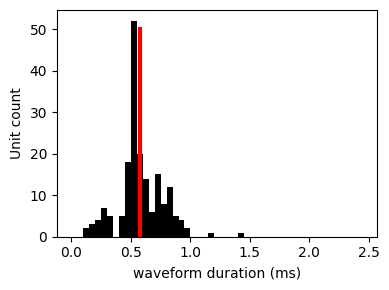

In [29]:
# Is this neuron a fast firing neuron?
print('The waveform duration of unit {} is {} ms'.format(unit, final_unit_table.loc[unit].waveform_duration))

# Histogram across all units
fig, ax = plt.subplots(figsize=[4,3])
_ = ax.hist(final_unit_table.waveform_duration, bins=np.arange(0, 2.5, 0.05), color='k')
ax.plot([final_unit_table.loc[unit].waveform_duration,final_unit_table.loc[unit].waveform_duration],[0,50], color='r', lw = 3)

# Formatting
ax.set_xlabel('waveform duration (ms)')
ax.set_ylabel('Unit count')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Equipped with a little bit of intuition that some of these neurons in the hippocampus might be correlated with the behavior state, we next want to replicate this analysis across a number of candidate neurons. 
    
<p> Will we see neurons that increase their activity in the disengaged state? Remain unchanged?
</div>

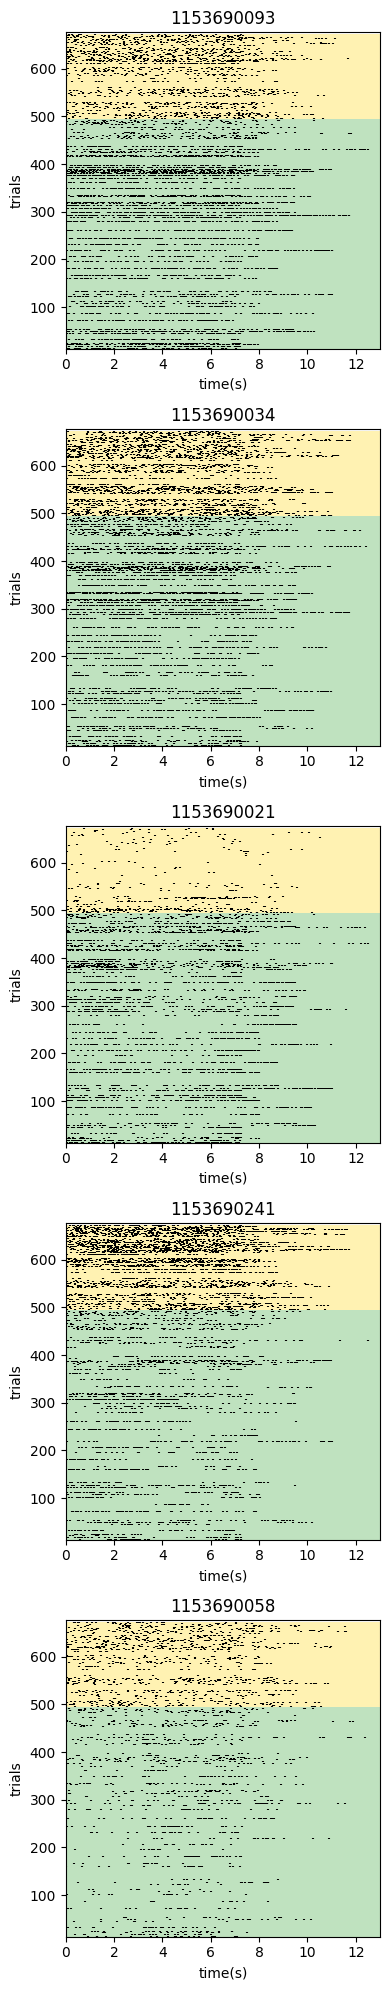

In [30]:
# We've identified a few interesting example units from CA1 of the hippocampus to explore
example_unit_ids = [1153690093, 1153690034, 1153690021, 1153690241, 1153690058]

# For convenience extract the start and stop times of each trial
start_times = trial_metadata[trial_metadata.go].start_time
stop_times = trial_metadata[trial_metadata.go].stop_time

fig, ax = plt.subplots(5,1, figsize = (4, 20))

# Here we will loop over the example units to do the following 1) extract spike times for each trials and 2) plot a raster.
for n, unit in enumerate(example_unit_ids):
    
    # Get spike times for one unit (this includes all spike across the session)
    unit_data = session.spike_times[unit]
    
    # Make a list of arrays, where each array includes the spike times for one trial
    spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    
    # Plot raster of spike times
    ax[n].eventplot(spike_times, color = 'k', lineoffsets = go_trials);
    
    # Add shading corresponding to the engaged and disengaged behavioral states
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.3)
        else:
            ax[n].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.3)
   
    # Format each axis in the loop
    ax[n].set_title(unit)    
    ax[n].set_ylim(go_trials[0], go_trials[-1]+4)
    ax[n].set_xlabel('time(s)')
    ax[n].set_xlim(0, 13)
    ax[n].set_ylabel('trials')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Here, we see a few different spiking patterns during the behavioral task in the hippocampus. In these example neurons, we see that spiking activity appears to change when the mouse switches from the "engaged" to the "disengaged" state. To see these effects more clearly, we can plot the mean firing rates of each of the neurons.
</div>

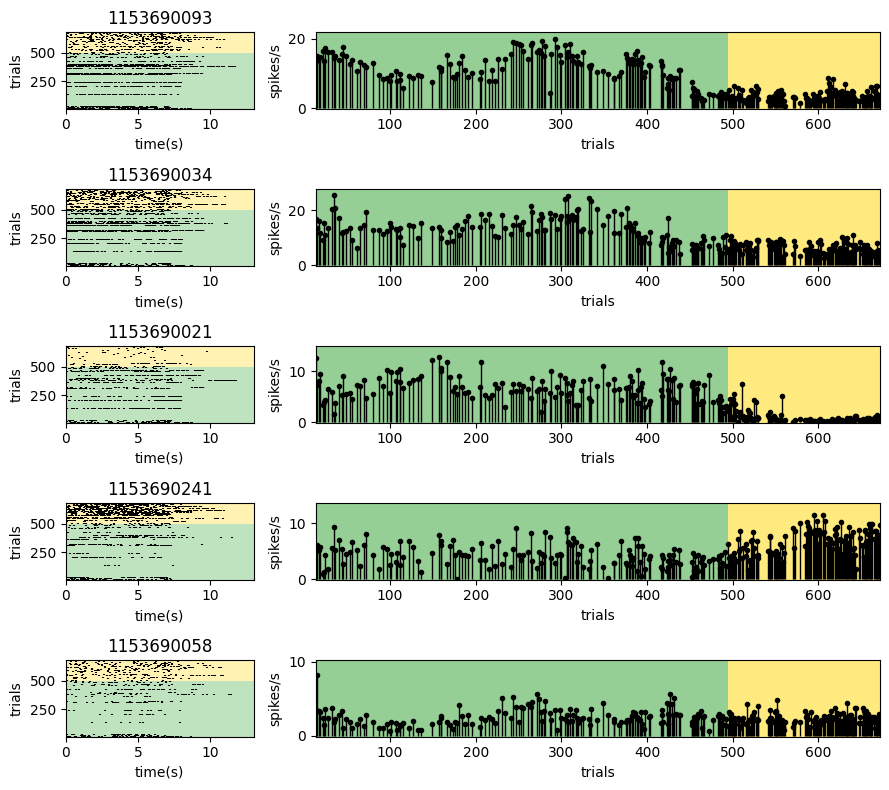

In [31]:
# In this cell we make the same set of rasters, but also add a second column of plots showing the trial-wise firing rate
fig,ax = plt.subplots(5, 2, figsize = (9, 8), gridspec_kw={'width_ratios': [1, 3]}) 

example_unit_ids = [1153690093, 1153690034, 1153690021, 1153690241, 1153690058]
for n, unit in enumerate(example_unit_ids):
    unit_data = session.spike_times[unit]
    spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
    
    # Compute the firing rate for each trial
    firing_rate = [len(spikes)/(s2 - s1) for spikes, s1, s2 in zip(spike_times, start_times, stop_times)]
    
    # Raster plot
    ax[n, 0].eventplot(spike_times, color = 'k', lineoffsets = go_trials);
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n, 0].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.3)
        else:
            ax[n, 0].axhspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.3)
    ax[n, 0].set_title(unit)    
    ax[n, 0].set_ylim(go_trials[0], go_trials[-1]+4)
    ax[n, 0].set_xlabel('time(s)')
    ax[n, 0].set_xlim(0, 13)
    ax[n, 0].set_ylabel('trials')

    # Plot of trial-wise firing rates
    markerline, stemlines, baseline = ax[n, 1].stem(go_trials, firing_rate, linefmt='k', basefmt='none', markerfmt = 'ok')
    plt.setp(markerline, markersize=3)
    plt.setp(stemlines,linewidth = 1)
    ax[n, 1].set_xlim(go_trials[0], go_trials[-1])
    for i, trial in enumerate(switch_trials[:-1]):
        if not states.values[trial+1]: 
            ax[n, 1].axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5)
        else:
            ax[n, 1].axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5)
    ax[n, 1].set_ylim(-0.1, np.max(firing_rate)+2)
    ax[n, 1].set_xlabel('trials')
    ax[n, 1].set_ylabel('spikes/s')
    
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We see decreased activity in many of these example neurons as the mouse transitions to a disengaged state. However, we also see neurons that increase their firing in the disengaged state or don't have any clear variation in activity due to the state switch. Thus, behavioral state can have diverse effects on neuronal activity and this is a very active line of research in the field. This functional diversity is thought to reflect structural, physiological, and genetic attributes of different cell types and brain regions.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> How is neuron activity correlated with running and pupil area?</h3>
    
<p> After all this, a natural followup question to close the loop on our behavior quantities is to ask: do these neurons correlate strongly with the behavioral traces we generated earlier? Pupil size? Running speed?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.5:</b> Plot up the relationship between behavioral variables and the firing rate of unit 1132690093.
    
<p> Complete the missing lines below in calculating the spike rate for the unit in question and plot a scatter plot with the with each trial summarized by the x value: the variance of the running speed, the y value: the mean pupil area and the color: the mean firing rate of the neuron.
    
<p> Once complete, discuss with your neighbors. Is this neuron strongly correlated with these behavioral variables and by extention, the behavior state?
    
<p> TODO: edit out the spike rate line for students to fill in.
</div>

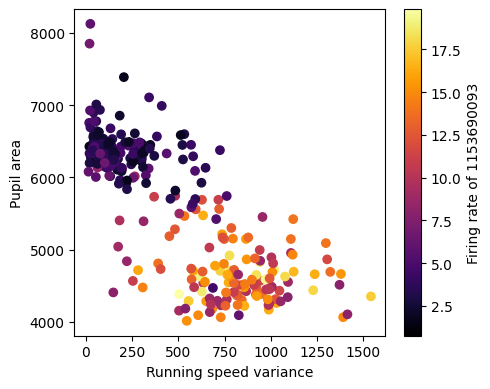

In [32]:
# Compute mean running speed in each go trial
var_speed = [np.nanvar(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]
# Compute mean pupil size in each go trial
mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# Let's calculate the average firing rate in each trial
unit = 1153690093
unit_data = session.spike_times[unit]

# define all the trials that we want to study
start_times = trial_metadata[trial_metadata.go].start_time
stop_times = trial_metadata[trial_metadata.go].stop_time

spike_times = [unit_data[np.logical_and(s1 <= unit_data, unit_data <= s2)] - s1 for s1, s2 in zip(start_times, stop_times)]
spike_rate = [float(spike_times[a].shape[0])/(stop_times[i]-start_times[i]) for a, i in enumerate(start_times.index)]

# complete the plotting routine
fig,ax = plt.subplots(figsize = [5,4])
scat = ax.scatter(var_speed, mean_pupil_area, c=spike_rate, cmap='inferno')
plt.colorbar(scat,label='Firing rate of {}'.format(unit))
ax.set_xlabel('Running speed variance')
ax.set_ylabel('Pupil area')
plt.tight_layout()
plt.show()

In [33]:
# Blank coding cell to work out Task 1.5


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In this workshop, we analyzed a mouse's behavior as it performed a visual change detection task. We identified two behavioral states using a simple performance metric: the hit rate. We summarized the behavioral profile in each state and observed changes in neural activity associated with state transitions. 
    
<p> However, our definition of behavioral states uses a crude thresholding methodology based on only a single variable. While a good starting point, this definition is incomplete. Moreover, we identified other behavioral metrics relevant to state transitions, yet we did not incorporate this information to define the behavioral states. This additional information could help us refine our understanding of behavioral states, introducing multiple latent states that are difficult to observe by simple eyeballing. In Workshop 2 in the afternoon, we will explore more sophisticated methods to define behavioral states that can incorporate multi-variate information about a mouse's behavioral profile. 

<p> In our current analyses, the threshold to define behavioral states "seemed" appropriate for the mouse we studied. However, the same thresholding techniques may not generalize across mice. Disengagement levels and their markers may vary across different mice. So, how can we systematically assess state changes across many mice? Let us tackle this question in Workshop 2. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Exercises </h2>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1: Try to find similar patterns in the Visual Behavior 2P dataset (**ADD LINK**). What are the behavioral responses like? Do you find any interesting cell-type specific patterns of engagement?  </b>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) get the <code>trials</code> dataframe from the session object. 
    
<p> 2) Filter the trials dataframe to get go trials only. 
    
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is the first lick time, in seconds, relative to the change time. 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: Determine behavioral states for each mouse by eyeballing the hit rate. Can you devise a systematic way to quantify this threshold? </b>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4a: How do running speed, pupil size and hit rate correlate for different mice? Do different transgenic mouse lines have different behavioral state statistics?  </b>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4b: Do different mice spend different amounts of time in “task engaged” vs “task disengaged” behavioral states? Make a histogram showing time in different states for a set of mice. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Can we use regression to predict state transition? </b>

<p> 1) Construct a design matrix using behavior input covariates.  
    
<p> 2) Use a threshold to determine states using hit rate.

<p> 3) Set up a regression model and evaluate model performance on state prediction. 
    
</div>